Using device: cpu
Loading MNIST dataset...
Preprocessing data...
(48999, 784) (10500, 784) (10501, 784) float64


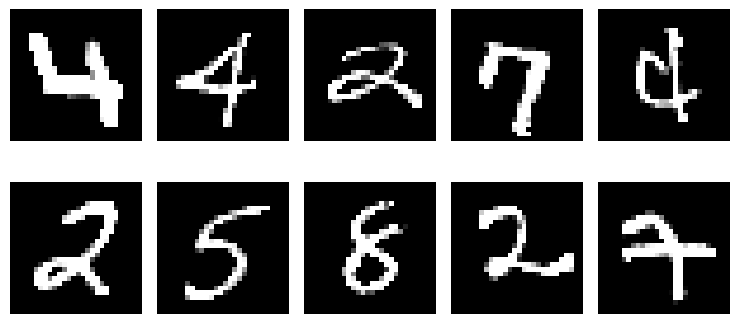

In [5]:
# ===============================
# Deep Neural Network using PyTorch made faster
# Dataset: MNIST (Handwritten Digit Recognition)
# ===============================

import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
from functools import partial
import optuna
from typing import List, Optional, Tuple
from dataclasses import dataclass
from tqdm import tqdm

# Choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.fastest = True
    torch.set_float32_matmul_precision('high')
else:
    torch.set_num_threads(os.cpu_count())

# Reproducibility
RNG_SEED = 42
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(RNG_SEED)

#  Mixed Precision & Dataloader Settings
USE_AMP = torch.cuda.is_available()   # enable AMP only if GPU is available
PIN_MEMORY = torch.cuda.is_available()  # pin_memory only makes sense on GPU


# =======================================
# 1. Load and Preprocess Data
# =======================================
def show_images(image, num_row=2, num_col=5):
    # plot images
    image_size = int(np.sqrt(image.shape[-1]))
    image = np.reshape(image, (image.shape[0], image_size, image_size))
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(image[i], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
print("Loading MNIST dataset...")
mnist_data = fetch_openml("mnist_784", version=1, as_frame=False)
X = mnist_data["data"]

# Normalize
print("Preprocessing data...")
scaler = StandardScaler()
X = scaler.fit_transform(X)

def train_val_test_split(X, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    X_train, X_temp = train_test_split(X, test_size=(1 - train_size), random_state=random_state)
    val_prop = val_size / (val_size + test_size)
    X_val, X_test = train_test_split(X_temp, test_size=(1 - val_prop), random_state=random_state)
    return X_train, X_val, X_test

X_train, X_val, X_test = train_val_test_split(X)
input_dim = X_train.shape[1]

# Usage:
X_train, X_val, X_test = train_val_test_split(X)
print(X_train.shape, X_val.shape, X_test.shape,  X_train.dtype)
input_dim = int(X_train.shape[1])
show_images(X_train)


# =======================================
# 2. Tensor Creation
# =======================================
def df_to_tensor_dataset(X):
    X_tensor = torch.tensor(X, dtype=torch.float)
    return TensorDataset(X_tensor)

def make_dataloaders(dataset, batch_size, shuffle=False):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, 
                      num_workers=os.cpu_count(), 
                      pin_memory=PIN_MEMORY, 
                      persistent_workers=True if os.cpu_count() > 1 else False
                    )

# Datasets
train_dataset = df_to_tensor_dataset(X_train)
val_dataset = df_to_tensor_dataset(X_val)
test_dataset = df_to_tensor_dataset(X_test)


# =======================================
# 3. Activation function
# =======================================
_ACTIVATION_MAP = {
    "relu": nn.ReLU,
    "sigmoid": nn.Sigmoid,
    "tanh": nn.Tanh,
    "leaky_relu": lambda: nn.LeakyReLU(negative_slope=0.01),
    "gelu": nn.GELU,
    "elu": nn.ELU,
    "softmax_logit": None  # handled as logits for CrossEntropy
}


# =======================================
# 4. Dataclass for hyperparameters
# =======================================
@dataclass
class TrainConfig:
    hidden_layers: list[int] = None
    activations: Optional[List[float]] = None
    dropout_rates: Optional[List[float]] = None
    loss_function: str = "cross_entropy"
    lr: float = 1e-3
    batch_size: int = 64
    epochs: int = 100
    weight_decay: float = 1e-5
    momentum: float = 0.9
    optimizer_type: str = "adam"
    step_size: int = 20
    gamma: float = 0.5
    early_stopping: bool = True
    patience: int = 10
    clip_grad_norm: Optional[float] = 1.0
    use_amp: bool = USE_AMP


# =======================================
# 5. Model Definition
# =======================================
class Autoencoder(nn.Module):
    def __init__(
        self, 
        input_dim: int, 
        hidden_layers: List[int], 
        activations: Optional[List[str]] = None, 
        dropout_rates: Optional[List[float]] = None
    ):
        super().__init__()
        layers = []
        prev = input_dim
        n_hidden = len(hidden_layers)
        if activations is None:
            activations = ["relu"] * n_hidden
        if dropout_rates is None:
            dropout_rates = [0.0] * n_hidden
        assert len(activations) == n_hidden
        assert len(dropout_rates) == n_hidden

        # Encoder
        for idx, h in enumerate(hidden_layers):
            layers.append(nn.Linear(prev, h))
            act_ctor = _ACTIVATION_MAP[activations[idx]]
            layers.append(act_ctor())
            if dropout_rates[idx] > 0:
                layers.append(nn.Dropout(dropout_rates[idx]))
            prev = h

        # Bottleneck size = hidden_layers[-1]

        # Decoder (reverse of encoder)
        for idx, h in enumerate(reversed(hidden_layers[:-1])):
            layers.append(nn.Linear(prev, h))
            layers.append(_ACTIVATION_MAP[activations[-(idx+2)]]())
            prev = h

        # Output layer
        layers.append(nn.Linear(prev, input_dim))
        layers.append(nn.Sigmoid())  # For normalized input
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)
    

# =======================================
# 6. Training Loop
# =======================================
def train_model(
    train_dataset, val_dataset,
    input_dim,
    config: TrainConfig,
    print_every=10, plot_loss=False
):  
    # Data preparation
    train_loader = make_dataloaders(train_dataset, config.batch_size, shuffle=True)
    val_loader = make_dataloaders(val_dataset, config.batch_size, shuffle=False)

    # Model creation
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.fastest = True
    model = Autoencoder(input_dim, config.hidden_layers, config.activations, config.dropout_rates)
    model.to(device)
    model = torch.compile(model) # if no C++ available add: , backend="aot_eager")

    if config.optimizer_type.lower() == "adam": # AdamW is the fastest and more stable option generally
        optimizer = optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    elif config.optimizer_type.lower() in ("sgd", "momentum"):
        optimizer = optim.SGD(model.parameters(), lr=config.lr, momentum=config.momentum, weight_decay=config.weight_decay)
    else:
        raise ValueError("Unsupported optimizer_type")
    
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config.step_size, gamma=config.gamma)
    criterion = nn.CrossEntropyLoss() if config.loss_function == "cross_entropy" else nn.MSELoss()
    scaler = torch.amp.GradScaler(enabled=config.use_amp)

    best_val_loss = float("inf")
    best_state = None
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(config.epochs):
        # Training
        model.train()
        train_loss = 0.0
        for (X_batch,) in train_loader:   # note the comma
            X_batch = X_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, X_batch)
            scaler.scale(loss).backward()
            if config.clip_grad_norm:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip_grad_norm)
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item() * X_batch.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (X_val_batch,) in val_loader:
                X_val_batch = X_val_batch.to(device, non_blocking=True)
                with torch.amp.autocast(device_type=device.type, enabled=config.use_amp):
                    outputs_val = model(X_val_batch)
                    loss_val = criterion(outputs_val, X_val_batch)
                val_loss += loss_val.item() * X_val_batch.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)
        scheduler.step()

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Print progress
        if (epoch+1) % print_every == 0:
            print(f"Epoch [{epoch+1}/{config.epochs}] | Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

         # Early stopping
        if config.early_stopping:
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= config.patience:
                    print("Early stopping triggered.")
                    break

    if best_state is not None:
        model.load_state_dict(best_state)

    if plot_loss:
        plt.figure(figsize=(6,4))
        plt.plot(train_losses, label="Train")
        plt.plot(val_losses, label="Val")
        plt.legend()
        plt.title("Loss over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

    return model

Epoch [5/30] | Train Loss: 0.8349 - Val Loss: 0.8230
Epoch [10/30] | Train Loss: 0.8061 - Val Loss: 0.7933
Epoch [15/30] | Train Loss: 0.7939 - Val Loss: 0.7797
Epoch [20/30] | Train Loss: 0.7867 - Val Loss: 0.7718
Epoch [25/30] | Train Loss: 0.7822 - Val Loss: 0.7672
Epoch [30/30] | Train Loss: 0.7792 - Val Loss: 0.7639


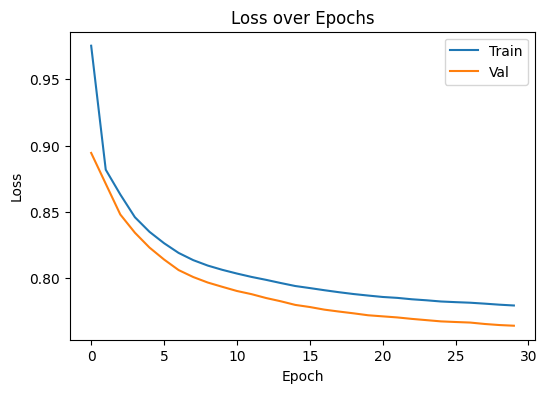


Final Test Reconstruction Loss: 0.788828


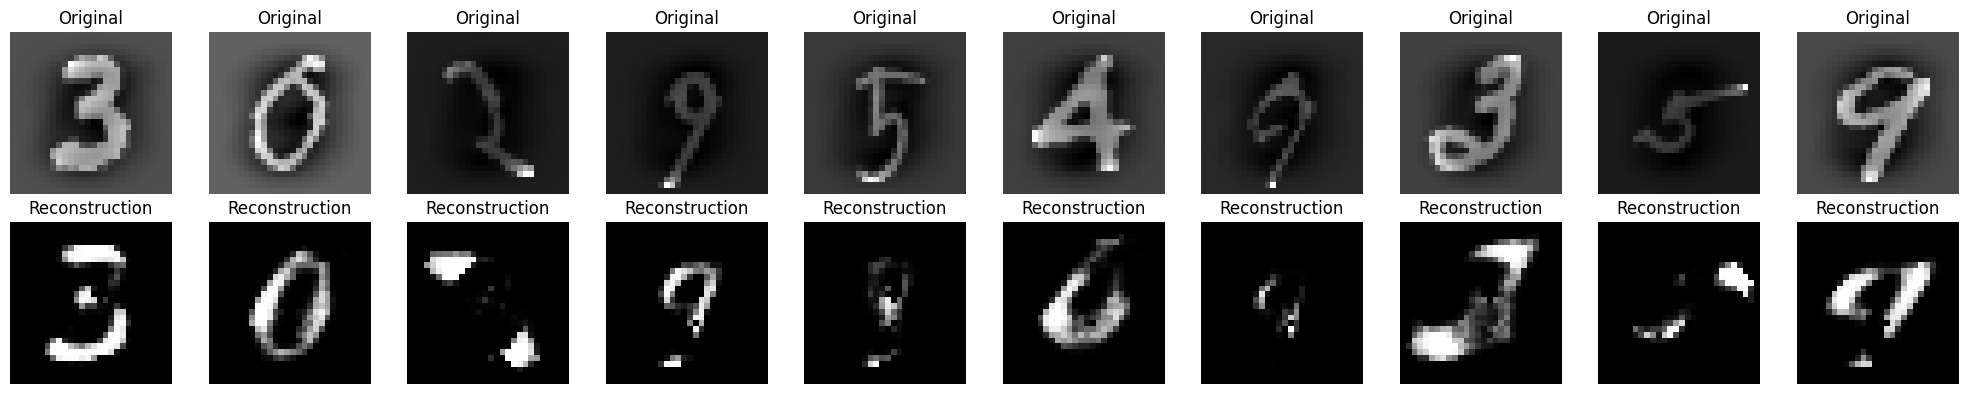

In [6]:
# =======================================
# 7. Make a test
# =======================================
config = TrainConfig(
    hidden_layers=[128, 64, 32],
    activations=["relu", "relu", "relu"],
    dropout_rates=[0.2, 0.2, 0.2],
    loss_function="mse",
    lr=1e-4, 
    batch_size=128, 
    epochs=30,
    weight_decay=1e-5,
    momentum=0.9,
    optimizer_type="adam",
    step_size=20,
    gamma=0.5, 
    early_stopping=True,
    patience=10,
    clip_grad_norm=1.0,
    use_amp=USE_AMP
) 

# Retrain final model
model = train_model(
    train_dataset, val_dataset,
    input_dim,
    config,
    print_every=5, plot_loss=True
)

# Evaluate on test set
test_loader = DataLoader(test_dataset, batch_size=config.batch_size)
# Evaluate model on test set
model.eval()
test_loss = 0.0
criterion = nn.MSELoss()

with torch.no_grad():
    for (X_batch,) in test_loader:
        X_batch = X_batch.to(device)
        reconstructed = model(X_batch)
        test_loss += criterion(reconstructed, X_batch).item() * X_batch.size(0)

test_loss /= len(test_loader.dataset)
print(f"\nFinal Test Reconstruction Loss: {test_loss:.6f}")


# =======================================
# 8. Visualize Reconstructions
# =======================================

def show_reconstructions(model, dataset, n=5):
    model.eval()
    loader = DataLoader(dataset, batch_size=n, shuffle=True)
    (X_batch,) = next(iter(loader))
    X_batch = X_batch.to(device)

    with torch.no_grad():
        X_hat = model(X_batch)

    X_batch, X_hat = X_batch.cpu().numpy(), X_hat.cpu().numpy()

    fig, axes = plt.subplots(2, n, figsize=(n*2, 4))
    for i in range(n):
        axes[0, i].imshow(X_batch[i].reshape(28, 28), cmap="gray")
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")

        axes[1, i].imshow(X_hat[i].reshape(28, 28), cmap="gray")
        axes[1, i].set_title("Reconstruction")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

# Display some reconstructed samples
show_reconstructions(model, test_dataset, n=10)